In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read Data and store on dataframes
movie_database = pd.read_csv('Small_Data/movies.csv')
users_ratings = pd.read_csv('Small_Data/ratings.csv')
tags_database = pd.read_csv('Small_Data/tags.csv')
links_database = pd.read_csv('Small_Data/links.csv')

In [3]:
# Display the first 10 items from the movies data set
movie_database[0:10]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [4]:
movie_database[movie_database['movieId']==1]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [5]:
# Display the first 5 items from the rating data set
users_ratings[0:5]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
# Shift users and movies ID by 1, so start at 0
users_ratings['userId'] = users_ratings['userId'] - 1
users_ratings['movieId'] = users_ratings['movieId'] - 1
movie_database['movieId'] = movie_database['movieId'] - 1

In [7]:
# Print ratings statistics describing numeric features
users_ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,325.127564,19434.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,0.000000,0.000000,0.500000,8.281246e+08
25%,176.000000,1198.000000,3.000000,1.019124e+09
50%,324.000000,2990.000000,3.500000,1.186087e+09
75%,476.000000,8121.000000,4.000000,1.435994e+09
max,609.000000,193608.000000,5.000000,1.537799e+09


In [8]:
'''
Alg:
1. Get userId list list_user
2. Get movieId list list_movie
3. For each user:
    a. Get ratings by user
    b. For each index of ratings in users_ratings dataframe:
        i. Get movieid index (column index) in ratings['movieId']
        ii. Append (user, movie, rating) to output list
4. Returns 3-tuple (output_list, list_user, list_movie)
'''
def get_user_item_pairs():
    list_userId = np.array(pd.unique(users_ratings['userId']))
    list_movieId = np.array(pd.unique(movie_database['movieId']))
    movie_index_list = pd.Index(movie_database['movieId'])
    output_list = []
    # index by user
    for user_index in np.arange(0, len(list_userId)):
        # associated user_id with user
        user_id = list_userId[user_index]
        # ratings by user
        ratings = users_ratings[users_ratings['userId'] == user_id]
        # for each row index associated with user
        for index in ratings.index:
            # get movie id for finding movie index
            movie_id = users_ratings['movieId'].iloc[index]
            # get movie index to place in list
            movie_index = movie_index_list.get_loc(movie_id)#movie_database['movieId'].loc[movie_id]
            # get rating
            rating = users_ratings['rating'].iloc[index]
            #rating = ratings['rating'].loc[index]
            #output_list.append((user_index, movie_index, rating))
            output_list.append([user_index,movie_index,rating])
    
    #output_list = np.array(output_list,dtype='i4,i4,i4')
    data_set = pd.DataFrame(output_list,columns=['user_idx','movie_idx','rating'])
    
    return(data_set,list_userId,list_movieId)
    #return (np.array(output_list, dtype='i4,i4,i4'), list_userId, list_movieId)
#     return (np.array(output_list, dtype=[('user_index', '<i4'), ('movie_index', '<i4'), ('rating', '<i4')]), list_userId, list_movieId)
'''
Input:
    S is a collection of 3-tuples (user, movie, rating)
        user is the index of the user in list_userId
        movie is the index of the movie in list_movieId
        rating is the corresponding rating
    Output: mxn feedback matrix
        m is the length of list_userId
        n is the length of list_movieId
        Entry (i, j) is nonzero if list_userId[i] reviewed list_movieId[j]
'''
def build_feedback_matrix(data_set, list_userId_len, list_movieId_len):
    """
    m = list_userId.shape[0]
    n = list_movieId.shape[0]
    F = np.zeros((m, n))
    for (user_index, movie_index, rating) in S:
        F[user_index, movie_index] = rating
    return F
    """
    feedback_matrix = np.zeros((list_userId_len,list_movieId_len))
    for index in data_set.index:
        user_index = data_set['user_idx'].loc[index]
        movie_index = data_set['movie_idx'].loc[index]
        rating = data_set['rating'].loc[index]
        feedback_matrix[user_index,movie_index] = rating
    
    return feedback_matrix


# Break the dataset into test and train sets
# Keep a 0.1 holdout fraction to construct test
def data_split(data,val_fraction=0.25,test_fraction=0.1):
    data_copy = data.copy()
    data_copy = data_copy.sample(frac=1)
    
    test_set = data_copy.sample(frac=test_fraction)
    
    hold_set = data_copy[~data_copy.index.isin(test_set.index)]
    val_set = hold_set.sample(frac=val_fraction)
    train_set = hold_set[~hold_set.index.isin(val_set.index)]

    return (train_set, val_set, test_set)

In [9]:
# Construct the data set based on the index of user, movies bind with the respective rating
# Build the list of usersIds
# Build the list of movieIds
(user_item_rating, list_userId, list_movieId)  = get_user_item_pairs()

In [10]:
# Split the data in train, validation and test set
# Get the 10% for test set
# Break the rest for 25% validation and 75% train
(train_data,val_data,test_data) = data_split(user_item_rating)

In [12]:
# Objetive function
# Implement Mean Square Error(MSE)
def calculate_loss(feedback_matrix,P,V):
    #Calculate the ratings matrix approximation
    predictions = np.dot(P,V.T)
    
    # Calculate the square error for each reating
    error_matrix = np.square((feedback_matrix - predictions))
    
    # Return the mean square error over the last dimension
    return np.mean(error_matrix)

In [51]:
class CF_Model(object):
    def __init__(self,users,movies):
        self.embedding_vars = {}
        self.train_loss = []
        self.val_loss = []
        self.list_userId = users
        self.list_movieId = movies
        self.num_users = users.shape[0]
        self.num_movies = movies.shape[0]
        self.num_features = 0
        self.models = []

    def embeddings(self):
        return self.embedding_vars
    
    def build_model(self,num_features=30,mu=0,std=1):
        """
            m: number of users
            n: number of movies
            k: number of features or latent factors   
            P: m x k: associative matrix btw Users and Features 
            V: n x k: associative matrix btw Movies and Features
        """
        self.num_features = num_features
        P = np.random.normal(loc=mu,scale=std,size=(self.num_users,num_features))
        V = np.random.normal(loc=mu,scale=std,size=(self.num_movies,num_features))
        self.embedding_vars['P'] = P
        self.embedding_vars['V'] = V
    
    def train(self,train_data,val_data,num_iter=100,learning_rate=0.00002,regulator=0.02):
        train_matrix = build_feedback_matrix(train_data,self.num_users,self.num_movies)
        val_matrix = build_feedback_matrix(val_data,self.num_users,self.num_movies)
        P = self.embedding_vars['P']
        V = self.embedding_vars['V'].T

        for epoch in range(num_iter):
            for i in range(self.num_users):
                for j in range(self.num_movies):
                    if train_matrix[i,j] > 0:
                        eij = train_matrix[i,j] - np.dot(P[i,:],V[:,j])
                        
                        for k in range(self.num_features):
                            gradient_P = 2 * eij * V[k,j] - regulator * P[i,k]
                            gradient_V = 2 * eij * P[i,k] - regulator * V[k,j]
                            P[i,k] = P[i,k] + learning_rate * gradient_P
                            V[k,j] = V[k,j] + learning_rate * gradient_V
          
            train_error = calculate_loss(train_matrix,P,V.T)
            val_error = calculate_loss(val_matrix,P,V.T)
            print("i: " + str(epoch) + " Train Loss: " + str(round(train_error,4)) + " - Validation Loss: " + str(round(val_error,4)))
            self.train_loss.append(train_error)
            self.val_loss.append(val_error)
            embedding_vars = {'P':P, 'V': V.T}
            self.models.append(embedding_vars)

    def update_best_model(self):
        min_validation_idx = np.argmin(self.val_loss)
        min_validation = np.min(self.val_loss)
        best_model = self.models[min_validation_idx]

        self.embedding_vars['P'] = best_model['P']
        self.embedding_vars['V'] = best_model['V']
        return min_validation
    
    def calculate_test_loss(self,test_data):
        test_matrix = build_feedback_matrix(test_data,self.num_users,self.num_movies)
        P = self.embedding_vars['P']
        V = self.embedding_vars['V']
        test_error = calculate_loss(test_matrix,P,V)
        return test_error

    def plot_loss(self):
        fig = plt.figure()
        fig.suptitle('Loss vs Number of Epochs')
        ax = fig.add_subplot(111)
        x1 = np.arange(len(self.train_loss))
        x2 = np.arange(len(self.val_loss))
        ax.plot(x1, self.train_loss, label='Train Data')
        ax.plot(x2, self.val_loss, label='Validation Data')
        ax.set_ylabel('MSE Loss')
        ax.set_xlabel('Epoch Number')
        plt.legend()
        plt.show()

    def compute_scores(self,query_embedding,item_embedding,similarity_mesure='dot'):
        """
            Similarity Mesure: Dot Product or Cosine
        """    
        if similarity_mesure == 'dot':
            score = np.dot(query_embedding,item_embedding.T)

        elif similarity_mesure == 'cos':
            query_norm = np.linalg.norm(query_embedding)
            item_norm = np.linalg.norm(item_embedding)
            score = np.dot(query_embedding,item_embedding.T) / (query_norm * item_norm)

        return score
    
    def display_rank(self,k_top_movies_id, k_top_scores,measure):
        movies_rank = pd.DataFrame()
        measure_key = measure + ' score'
        for i in range(len(k_top_movies_id)):
            movie_id = k_top_movies_id[i]
            movie = movie_database[movie_database['movieId']==movie_id].copy()
            movie = movie.drop('genres',axis=1)
            movie[measure_key] = k_top_scores[i]        
            movies_rank = movies_rank.append(movie)
        
        movies_rank = movies_rank.sort_values([measure_key],ascending=False)
        display(movies_rank)
    
    def user_base_rank(self,user_id,list_users_id,list_movies_id,num_recomendations=5,measure='dot'):
        user_index = -1 
        user_index = np.where(list_users_id==user_id)
        if user_index ==  -1:
            print("Error: User Id not valid, Not Found")
            return
        
        users_embeddings = self.embedding_vars['P']
        movies_embeddings = self.embedding_vars['V']

        user_embedding = users_embeddings[user_index]
        scores = self.compute_scores(user_embedding,movies_embeddings,similarity_mesure=measure)[-1]
    
        k_top_scores_index = np.argsort(scores)[-1*num_recomendations:]
        k_top_scores = scores[k_top_scores_index]

        k_top_moviesId = list_movies_id[k_top_scores_index]
    
        self.display_rank(k_top_moviesId,np.around(k_top_scores,2),measure)
    
    def movie_base_rank(self,movie_title,list_movies_id,num_recomendations=5,measure='dot'):
        movies_index = movie_database[movie_database['title'].str.contains(movie_title)].index.values
        if len(movies_index) == 0:
            print("Error: " + movie_title)
            print("Movie Title invalid, Not Found")
            return
    
        movie_index = movies_index[0]
        movies_embeddings = self.embedding_vars['V']
        movie_embedding = movies_embeddings[movie_index]

        scores = self.compute_scores(movie_embedding,movies_embeddings,similarity_mesure=measure)

        k_nearest_scores_index = np.argsort(scores)[-1*num_recomendations:]
        k_nearest_scores = scores[k_nearest_scores_index]

        k_nearest_moviesId = list_movies_id[k_nearest_scores_index]

        self.display_rank(k_nearest_moviesId,np.around(k_nearest_scores,2),measure)

In [52]:
model = CF_Model(list_userId, list_movieId)

In [53]:
model.build_model(num_features=5)

In [54]:
model.train(train_data,val_data,num_iter=70,learning_rate=0.0001)

i: 0 Train Loss: 4.8765 - Validation Loss: 4.7741
i: 1 Train Loss: 4.6964 - Validation Loss: 4.5946
i: 2 Train Loss: 4.5396 - Validation Loss: 4.4383
i: 3 Train Loss: 4.4012 - Validation Loss: 4.3002
i: 4 Train Loss: 4.2774 - Validation Loss: 4.1768
i: 5 Train Loss: 4.1657 - Validation Loss: 4.0655
i: 6 Train Loss: 4.0642 - Validation Loss: 3.9643
i: 7 Train Loss: 3.9713 - Validation Loss: 3.8718
i: 8 Train Loss: 3.8858 - Validation Loss: 3.7866
i: 9 Train Loss: 3.8068 - Validation Loss: 3.7079
i: 10 Train Loss: 3.7335 - Validation Loss: 3.6348
i: 11 Train Loss: 3.6652 - Validation Loss: 3.5668
i: 12 Train Loss: 3.6014 - Validation Loss: 3.5032
i: 13 Train Loss: 3.5416 - Validation Loss: 3.4436
i: 14 Train Loss: 3.4854 - Validation Loss: 3.3876
i: 15 Train Loss: 3.4325 - Validation Loss: 3.335
i: 16 Train Loss: 3.3827 - Validation Loss: 3.2853
i: 17 Train Loss: 3.3355 - Validation Loss: 3.2383
i: 18 Train Loss: 3.2909 - Validation Loss: 3.1939
i: 19 Train Loss: 3.2486 - Validation Loss

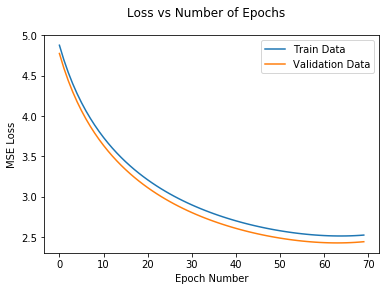

In [55]:
model.plot_loss()

In [56]:
min_validation = model.update_best_model()

In [57]:
print(min_validation)

2.426169263095268


In [58]:
test_error = model.calculate_test_loss(test_data)

In [59]:
print(test_error)

2.414830409301387


In [60]:
model.user_base_rank(1,list_userId,list_movieId,5,'cos')

,movieId,title,cos score
6853,62112,How to Lose Friends & Alienate People (2008),0.02
8445,111912,Lilting (2014),0.02
735,954,Bringing Up Baby (1938),0.02
2619,3503,Network (1976),0.01
5340,8904,1492: Conquest of Paradise (1992),0.01


In [61]:
model.user_base_rank(1,list_userId,list_movieId,5,'dot')

,movieId,title,dot score
735,954,Bringing Up Baby (1938),5.89
8445,111912,Lilting (2014),5.86
6853,62112,How to Lose Friends & Alienate People (2008),5.69
5340,8904,1492: Conquest of Paradise (1992),5.35
2619,3503,Network (1976),5.34


In [62]:
model.movie_base_rank('Aladdin',list_movieId,measure='dot')

,movieId,title,dot score
6105,42637,Grand Theft Parsons (2003),5.17
9184,149405,Kung Fu Panda 3 (2016),5.07
7565,85564,Chalet Girl (2011),4.69
3365,4572,Blaze (1989),4.68
8203,103365,Redemption (Hummingbird) (2013),4.48


In [63]:
model.movie_base_rank('Aladdin',list_movieId,measure='cos')

,movieId,title,cos score
7565,85564,Chalet Girl (2011),0.02
9184,149405,Kung Fu Panda 3 (2016),0.02
6105,42637,Grand Theft Parsons (2003),0.02
8203,103365,Redemption (Hummingbird) (2013),0.01
3365,4572,Blaze (1989),0.01
